# Deep Learning for Predictive Maintenance

Following https://github.com/Azure/lstms_for_predictive_maintenance

The **training data** consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. When a predefined threshold is reached, then the engine is considered unsafe for further operation. In other words, the last cycle in each time series can be considered as the failure point of the corresponding engine. Taking the sample training data shown in the following table as an example, the engine with id=1 fails at cycle 192, and engine with id=2 fails at cycle 287.   

The **testing data** has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs. Taking the sample testing data shown in the following table as an example, the engine with id=1 runs from cycle 1 through cycle 31. It is not shown how many more cycles this engine can last before it fails.   

Finally, the **ground truth data** provides the number of remaining working cycles for the engines in the testing data. Eg. the engine with id=1 in the testing data can run another 112 cycles before it fails.

In [1]:
import keras

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

## Import the data

In [4]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)  # 26-27 extra empty space
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [7]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Labeling
**Regression models**: How many more cycles an in-service engine will last before it fails?  
**Binary classification**: Is this engine going to fail within w1 cycles?  
**Multi-class classification**: Is this engine going to fail within the window [1, w0] cycles or to fail within the window [w0+1, w1] cycles, or it will not fail within w1 cycles?

"RUL", label1", and "label2" are labels for regression, binary classification, and multi-class classification models respectively. Here w0 and w1 are predefined use case related parameters which are used to label the training data. One needs to decide how far ahead of time the alert of failure should trigger before the actual failure event. 

In [8]:
(train_df.groupby('id')['cycle'].max()).head()

id
1    192
2    287
3    179
4    189
5    269
Name: cycle, dtype: int64

In [9]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head(3)

,id,max
0,1,192
1,2,287
2,3,179


In [10]:
# Data Labeling - generate column RUL
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [11]:
w0 = 15
w1 = 30
train_df['label1'] = np.where(train_df['RUL']<=w1, 1, 0)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL']<=w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


### MinMax Norm

In [12]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
no_norm_col = ['id','cycle','RUL','label1','label2']
norm_col    = train_df.columns.difference(no_norm_col)

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[norm_col]), 
                             columns=norm_col, 
                             index=train_df.index)

In [14]:
join_df = train_df[no_norm_col].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head(3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554


Normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[norm_col]), #no fit 
                            columns= norm_col, 
                            index=test_df.index)

test_join_df = test_df[test_df.columns.difference(norm_col)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Use the ground truth dataset to generate labels for the test data.

In [17]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [18]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [19]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head(3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0


## View of Data

In [22]:
# preparing data for visualizations 
engine_id3 = test_df[test_df['id'] == 2]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

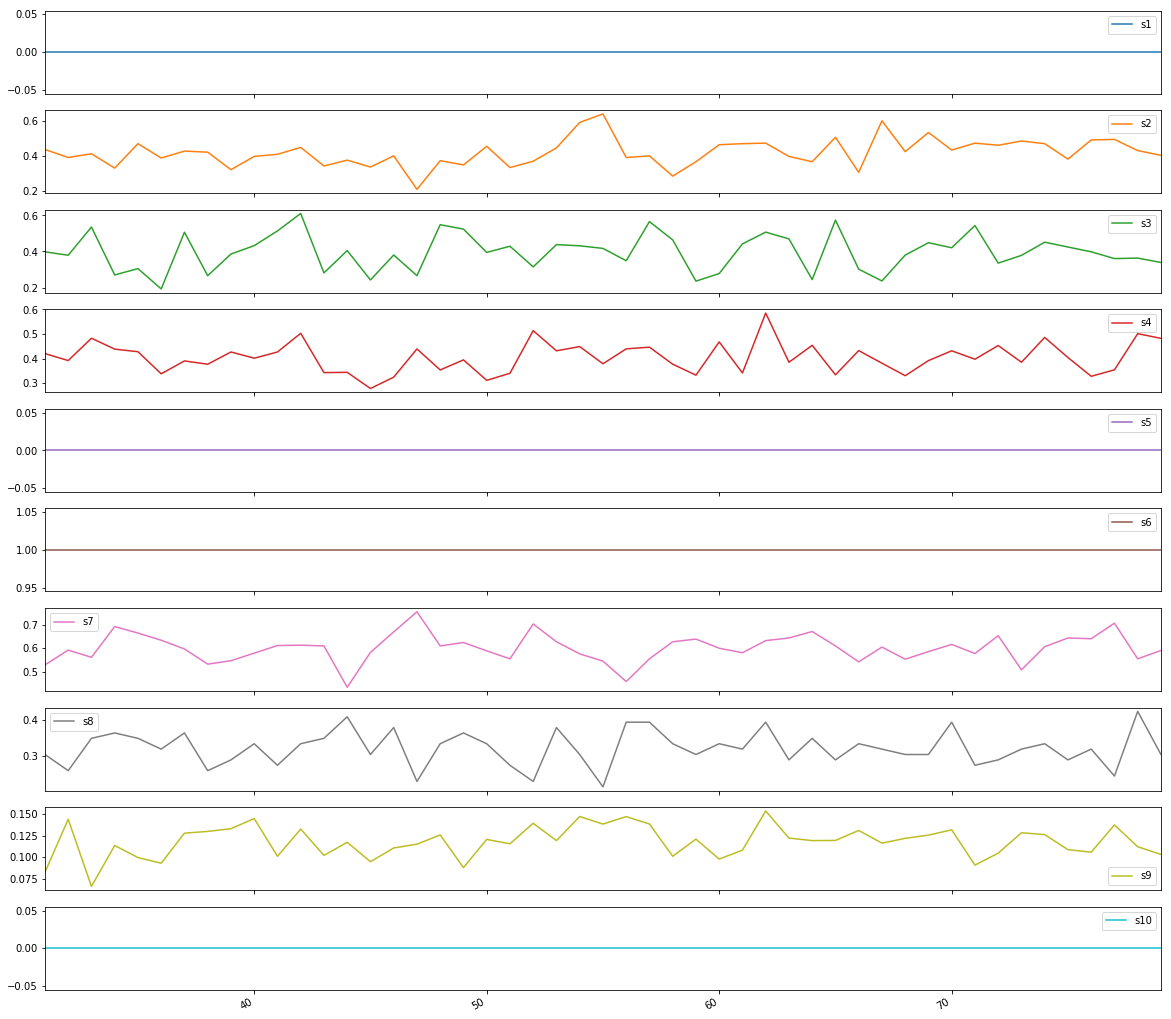

In [23]:
ax1 = engine_id3[cols1].plot(subplots=True, sharex=True, figsize=(20,20))

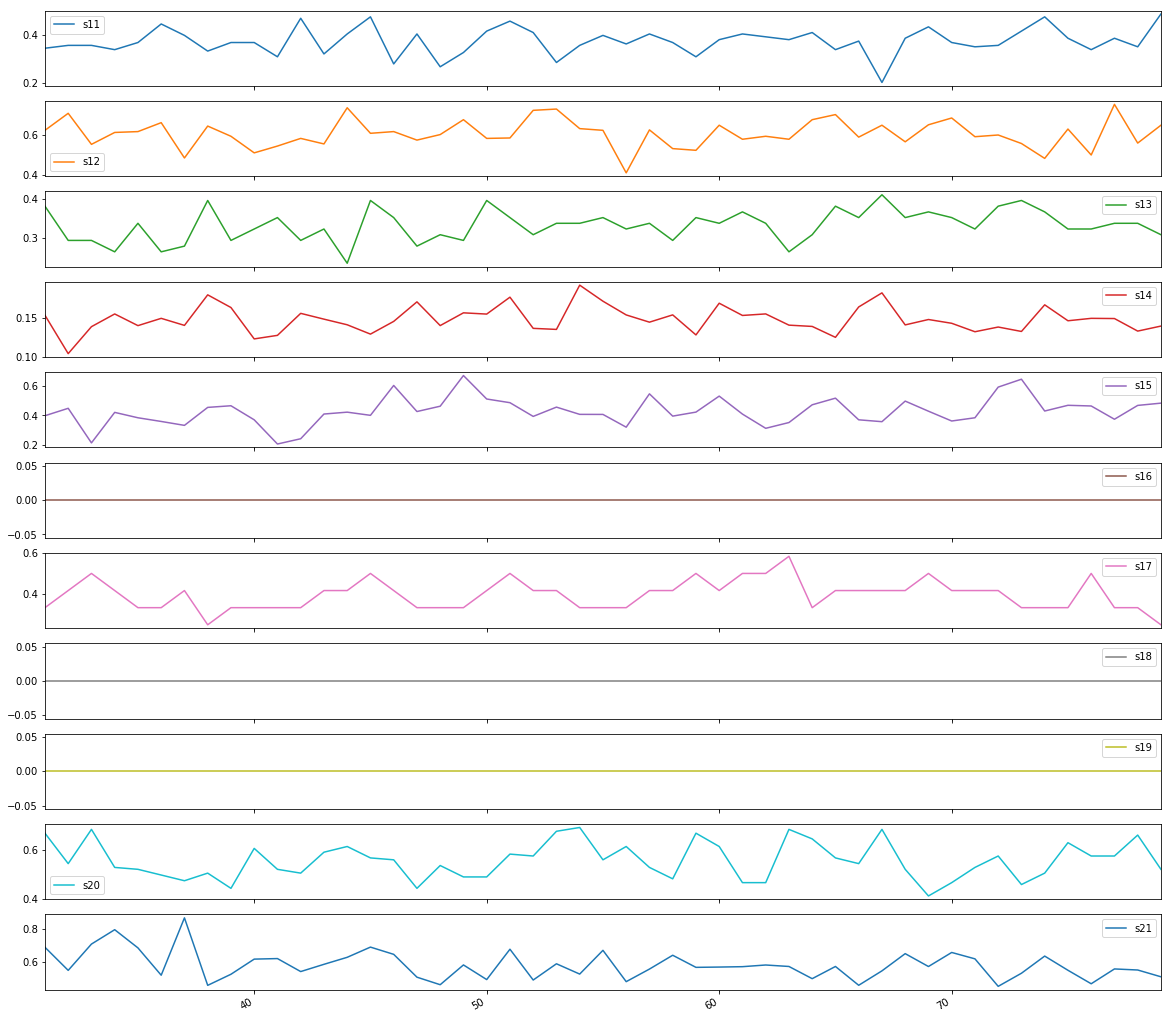

In [24]:
ax1 = engine_id3[cols2].plot(subplots=True, sharex=True, figsize=(20,20))

When using LSTMs in the time-series domain, one important parameter to pick is the sequence length which is the window for LSTMs to look back. This may be viewed as similar to picking window_size = 5 cycles for calculating the rolling features which are rolling mean and rolling standard deviation for 21 sensor values. The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

In [25]:
# pick a large window size of 50 cycles
sequence_length = 50

In [26]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing we need to drop 
    those which are below the window-length. An alternative would be to pad sequences so that we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [27]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [28]:
# generator for the sequences for each id 
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [29]:
# generate sequences and convert to numpy array       (None, Seq_length, dimension)
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

## Binary classification: 
Is this engine going to fail within w1 cycles?

In [30]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [31]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]

In [32]:
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [52]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.1, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')])

Train on 14067 samples, validate on 1564 samples
Epoch 1/10
14067/14067 [==============================] - 12s - loss: 0.0952 - acc: 0.9623 - val_loss: 0.0650 - val_acc: 0.9757
Epoch 2/10
14067/14067 [==============================] - 12s - loss: 0.0828 - acc: 0.9644 - val_loss: 0.0704 - val_acc: 0.9712
Epoch 3/10
14067/14067 [==============================] - 12s - loss: 0.0728 - acc: 0.9696 - val_loss: 0.0442 - val_acc: 0.9879
Epoch 4/10
14067/14067 [==============================] - 12s - loss: 0.0648 - acc: 0.9718 - val_loss: 0.0453 - val_acc: 0.9859
Epoch 5/10
14067/14067 [==============================] - 11s - loss: 0.0622 - acc: 0.9750 - val_loss: 0.0787 - val_acc: 0.9591
Epoch 6/10
14067/14067 [==============================] - 12s - loss: 0.0647 - acc: 0.9714 - val_loss: 0.0515 - val_acc: 0.9738
Epoch 7/10
14067/14067 [==============================] - 12s - loss: 0.0569 - acc: 0.9770 - val_loss: 0.0429 - val_acc: 0.9783
Epoch 8/10
14067/14067 [==============================]

### Performance on the training dataset

In [57]:
pred = model.predict(seq_array)

In [100]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 3s     
Accurracy: 0.9806793742289387


In [102]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.960197368421 
 recall =  0.941612903226


### Performance on the test dataset  
 pick the last sequence for each id in the test data.

In [31]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [32]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [33]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [34]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [35]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

Accurracy: 0.9784946178877225


In [36]:
# make predictions and compute confusion matrix
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

93/93 [==============================] - 0s     
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 1, 24]])

In [37]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.96 
 Recall:  0.96 
 F1-score: 0.96


In [38]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.978495,0.960000,0.96,0.960000
Template Best Model,0.940000,0.952381,0.80,0.869565


## Multi-class Classification

In [28]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label2']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [36]:
from keras.utils.np_utils import to_categorical
label_binary = to_categorical(label_array)

In [43]:
print (seq_array.shape)
print (label_binary.shape)

(15631, 50, 25)
(15631, 3)


In [53]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_binary.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 100)           50400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 80,753
Trainable params: 80,753
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
%%time
# fit the network
model.fit(seq_array, label_binary, epochs=20, batch_size=200, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')])

Train on 14067 samples, validate on 1564 samples
Epoch 1/20
12s - loss: 0.5915 - acc: 0.7992 - val_loss: 0.3489 - val_acc: 0.8664
Epoch 2/20
11s - loss: 0.2789 - acc: 0.8888 - val_loss: 0.1990 - val_acc: 0.8971
Epoch 3/20
11s - loss: 0.1800 - acc: 0.9308 - val_loss: 0.1452 - val_acc: 0.9380
Epoch 4/20
11s - loss: 0.1565 - acc: 0.9374 - val_loss: 0.1435 - val_acc: 0.9476
Epoch 5/20
11s - loss: 0.1217 - acc: 0.9527 - val_loss: 0.0901 - val_acc: 0.9623
Epoch 6/20
11s - loss: 0.1144 - acc: 0.9532 - val_loss: 0.1049 - val_acc: 0.9514
Epoch 7/20
11s - loss: 0.1125 - acc: 0.9537 - val_loss: 0.0970 - val_acc: 0.9578
Epoch 8/20
11s - loss: 0.1115 - acc: 0.9524 - val_loss: 0.0801 - val_acc: 0.9655
Epoch 9/20
11s - loss: 0.0996 - acc: 0.9594 - val_loss: 0.0712 - val_acc: 0.9712
Epoch 10/20
11s - loss: 0.0972 - acc: 0.9599 - val_loss: 0.0862 - val_acc: 0.9584
Epoch 11/20
11s - loss: 0.1029 - acc: 0.9588 - val_loss: 0.0809 - val_acc: 0.9668
Epoch 12/20
11s - loss: 0.0871 - acc: 0.9639 - val_loss: 0

In [56]:
pred = model.predict(seq_array) 

In [57]:
pred

array([[  9.46916163e-01,   7.22463519e-05,   3.45670742e-05],
       [  9.46778059e-01,   7.29207895e-05,   3.45292501e-05],
       [  9.46623266e-01,   7.40103715e-05,   3.43726388e-05],
       ..., 
       [  1.01644150e-03,   2.45704176e-03,   9.35743690e-01],
       [  1.02279498e-03,   2.39242148e-03,   9.38345313e-01],
       [  1.03406864e-03,   2.35858350e-03,   9.40883338e-01]], dtype=float32)

In [59]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [60]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [61]:
label_array_test_last = test_df.groupby('id')['label2'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [63]:
# test metrics
label_test_last = to_categorical(label_array_test_last)

scores_test = model.evaluate(seq_array_test_last, label_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

Accurracy: 0.9569892415436365


## Regression

In [27]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

print (seq_array.shape)
print (label_array.shape)

(15631, 50, 25)
(15631, 1)


In [28]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         activation='relu',
         return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=nb_out, activation='relu'))
model.compile(loss='mse', optimizer='adam')

In [169]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=200, batch_size=200, validation_split=0.2, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')])

Train on 12504 samples, validate on 3127 samples
Epoch 1/200
10s - loss: 813.8433 - val_loss: 1381.0311
Epoch 2/200
10s - loss: 734.7533 - val_loss: 1566.0093
Epoch 3/200
10s - loss: 728.4518 - val_loss: 1364.6607
Epoch 4/200
10s - loss: 715.0093 - val_loss: 1961.4512
Epoch 5/200
10s - loss: 734.4978 - val_loss: 1562.4881
Epoch 6/200
10s - loss: 669.4060 - val_loss: 1338.8448
Epoch 7/200
10s - loss: 699.7630 - val_loss: 1618.5657
Epoch 8/200
10s - loss: 673.3126 - val_loss: 1429.3455
Epoch 9/200
10s - loss: 695.6772 - val_loss: 1291.5357
Epoch 10/200
10s - loss: 690.2367 - val_loss: 1951.5294
Epoch 11/200
10s - loss: 637.6056 - val_loss: 1555.8545
Epoch 12/200
10s - loss: 665.0218 - val_loss: 1248.0546
Epoch 13/200
10s - loss: 619.6954 - val_loss: 1425.2371
Epoch 14/200
10s - loss: 634.2366 - val_loss: 1468.3889
Epoch 15/200
10s - loss: 617.5185 - val_loss: 1266.4209
Epoch 16/200
10s - loss: 595.1797 - val_loss: 1566.0983
Epoch 17/200
10s - loss: 594.8851 - val_loss: 1246.5745
Epoch 18

In [112]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print (label_array_test_last.shape)
print (seq_array_test_last.shape)

(93, 1)
(93, 50, 25)


In [164]:
pred = model.predict(seq_array_test_last)

In [165]:
np.sqrt(np.mean((np.power((pred - label_array_test_last), 2))))

17.968

In [181]:
for i in range(label_array_test_last.shape[0]):
    print(pred[i], label_array_test_last[i])

[ 60.80243301] [ 69.]
[ 93.36148071] [ 82.]
[ 90.7669754] [ 91.]
[ 100.91919708] [ 93.]
[ 120.32470703] [ 91.]
[ 80.66047668] [ 95.]
[ 130.20161438] [ 111.]
[ 74.35479736] [ 96.]
[ 77.43904114] [ 97.]
[ 103.02342987] [ 124.]
[ 102.59822845] [ 95.]
[ 88.91249847] [ 83.]
[ 85.77272034] [ 84.]
[ 44.27511597] [ 50.]
[ 30.82645607] [ 28.]
[ 75.98959351] [ 87.]
[ 16.28736687] [ 16.]
[ 75.76327515] [ 57.]
[ 85.65333557] [ 113.]
[ 21.11915779] [ 20.]
[ 117.77825165] [ 119.]
[ 59.50862503] [ 66.]
[ 126.7206192] [ 97.]
[ 102.02581787] [ 90.]
[ 74.85276794] [ 115.]
[ 5.89223862] [ 8.]
[ 36.19331741] [ 48.]
[ 123.90805817] [ 106.]
[ 6.75319576] [ 7.]
[ 12.0616951] [ 11.]
[ 21.86255455] [ 19.]
[ 24.16764259] [ 21.]
[ 62.62150955] [ 50.]
[ 20.95853043] [ 28.]
[ 16.25046921] [ 18.]
[ 7.3992734] [ 10.]
[ 82.30561829] [ 59.]
[ 139.60548401] [ 109.]
[ 92.30233002] [ 114.]
[ 36.55072784] [ 47.]
[ 109.31214142] [ 135.]
[ 161.86694336] [ 92.]
[ 22.38647652] [ 21.]
[ 100.3497467] [ 79.]
[ 100.53473663] [ 11

In [41]:
np.mean(np.absolute(pred - label_array_test_last))

12.731684

In [51]:
def plot_residual(model, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """   
    plt.scatter(y_test_pred, y_test_pred - y_test, c='blue', marker='o', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-20, xmax=200, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

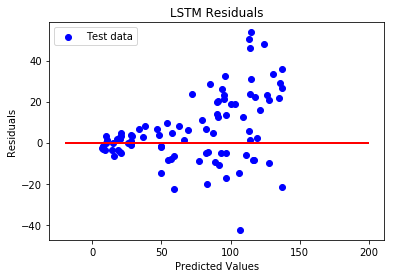

In [52]:
plot_residual('LSTM', pred, label_array_test_last)

## Future Directions and Improvements
This tutorial covers the basics of using deep learning in predictive maintenance and many predictive maintenance problems usually involve a variety of data sources that needs to be taken into account when applying deep learning in this domain. Additionally, it is important to tune the models for the right parameters such as window size. Here are some suggestions on future directions on improvements:
- Try different window sizes.
- Try different architectures with different number of layers and nodes.
- Try tuning hyperparmeters of the network.

- Try on larger data sets with more records.
- Try a different problem scenario such as in [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1) where multiple other data sources are involved such as maintenance records.